In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
print(device)
dtype = torch.float32

cuda


In [5]:
# Importing MNIST train and test data
train_data = datasets.CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(len(train_data), len(test_data))
print(train_data[0][0].shape)

50000 10000
torch.Size([3, 32, 32])


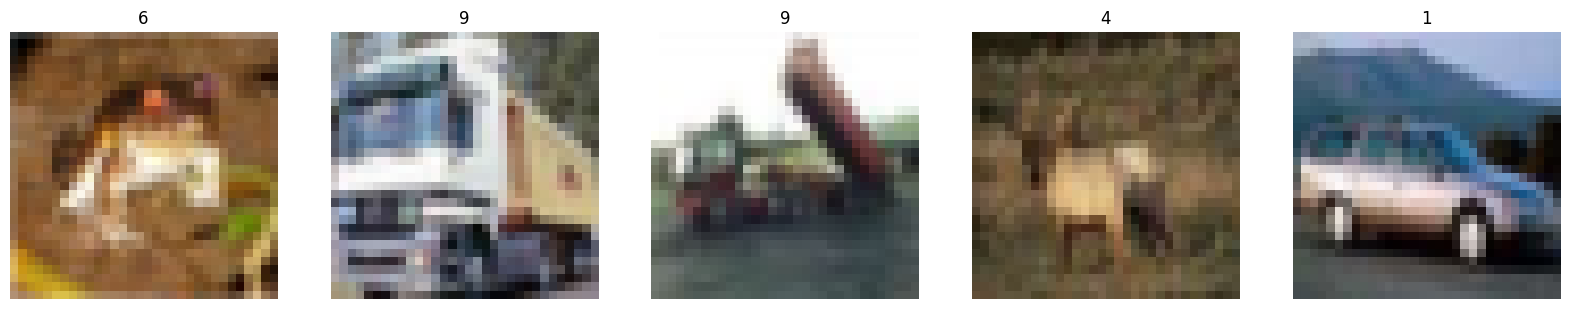

In [7]:
# Visualizing some samples
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
  ax[i].imshow(train_data[i][0].permute(1, 2, 0))
  ax[i].set_title(train_data[i][1])
  ax[i].axis('off')

In [6]:
# class MyModel(nn.Module):
#     def __init__ (self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.Linear(hidden_dim*7*7, output_dim)
#         )

#     def forward(self, x):
#         return self.main(x)

# class MyModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.Linear(hidden_dim * 8 * 8, output_dim)  # Adjusted the input size for the linear layer
#         )

#     def forward(self, x):
#         return self.main(x)



In [8]:
import torch
from torchvision.models import resnet18

class MyModel(nn.Module):
    def __init__(self, output_dim):  # Only output_dim is needed
        super().__init__()
        # Load pre-trained ResNet18 model and freeze its weights
        self.resnet = resnet18(pretrained=True)

        # Adjust the final layer to match your output dimension
        # self.flatten = nn.Flatten()

        self.flatten = nn.Flatten()  # Add the flatten layer
        self.fc = nn.Linear(1000, output_dim,bias=True)  # Input size based on pre-trained model


    def forward(self, x):
        # Pass the input through the ResNet18 model
        x = self.resnet(x)
        # print("X ka shape after resnet ",x.shape)
        # Apply the final linear layer
        # print("X ka shape before flatten ",x.shape)
        x= self.flatten(x)
        # print("X ka shape aafter flatten ",x.shape)
        x = self.fc(x)
        # print("X ka shape which is output",x.shape)

        return x



In [9]:
def check_acc(data, model, loss_fn):
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    with torch.no_grad():
        for x, y in data:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _,preds = scores.max(1)
            total_loss += loss_fn(scores, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    return acc, loss


## Adversarial Testing

In [10]:
def train_model(model, train_data, test_data, loss_fn, num_epochs=20, batch_size=64):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
    accuracy = 0
    for epoch in range(num_epochs):
        train_loss = 0
        for t, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            # print("inside train",x.shape)

            train_preds = model(x)
            loss = loss_fn(train_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_acc, _ = check_acc(train_loader, model, loss_fn)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        #save the highest accuracy model 
        
        if train_acc > accuracy and train_acc > 0.95:
            accuracy = train_acc
            torch.save(model.state_dict(), 'best_model100.pth')


def eval_model(model, test_data, loss_fn):
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    test_acc, test_loss = check_acc(test_loader, model, loss_fn)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')



def eval_untargetted_fgsm(model, test_data, loss_fn, e=0.1):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            scores = model(x)
            loss = loss_fn(scores, y)
            model.zero_grad()
            loss.backward()
            x_grad = x.grad.data
            x_adv = x + e * x_grad.sign()
            x_adv = torch.clamp(x_adv, 0, 1)
            out_adv = model(x_adv)
            _,preds = out_adv.max(1)
            total_loss += loss_fn(out_adv, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    print(f'Untargetted FGSM Test Loss: {loss:.4f}, Untargetted FGSM Test Acc: {acc:.4f}')
    return acc

# write code for targetted fgsm attack
def eval_targeted_fgsm(model, test_data, loss_fn, target_label, e=0.1):
    test_loader = DataLoader(test_data, batch_size=20, shuffle=False)
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    target_label = target_label.to(device=device, dtype=torch.long)
    
    for x, y in test_loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            scores = model(x)
            # loss1 = loss_fn(scores, y)
            # loss2 = loss_fn(scores, target_label)
            # loss = loss1-loss2
            loss = loss_fn(scores, target_label)
            model.zero_grad()
            loss.backward()
            x_grad = x.grad.data
            x_adv = x - e * x_grad.sign()
            x_adv = torch.clamp(x_adv, 0, 1)
            out_adv = model(x_adv)
            _,preds = out_adv.max(1)
            total_loss += loss_fn(out_adv, y).item()
            n_samples += preds.size(0)
            n_correct += (preds == y).sum()
            n_batches += 1
    acc = float(n_correct/n_samples)
    loss = float(total_loss/n_batches)
    print(f'Targetted FGSM Test Loss: {loss:.4f}, Targetted FGSM Test Acc: {acc:.4f}')
    return acc

def eval_untargetted_mim(model, test_data, loss_fn, eps=0.1, alpha=0.9):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]))
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    momentum = 0

    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        x.requires_grad = True
        scores = model(x)
        loss = loss_fn(scores, y)
        model.zero_grad()
        loss.backward()
        x_grad = x.grad.data

        # Update momentum and create adversarial example
        momentum = alpha * momentum + (1 - alpha) * x_grad.sign()
        x_adv = x + eps * momentum

        # Clip adversarial example to valid range
        x_adv = torch.clamp(x_adv, 0, 1)

        out_adv = model(x_adv)
        _, preds = out_adv.max(1)
        total_loss += loss_fn(out_adv, y).item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum()
        n_batches += 1

    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Untargetted MIM Test Loss: {loss:.4f}, Untargetted MIM Test Acc: {acc:.4f}')
    return acc

def eval_targetted_mim(model, test_data, loss_fn, eps=0.1, alpha=0.9, target_label=1):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]))
    target_label = target_label.to(device=device, dtype=torch.long)
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    momentum = 0

    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        x.requires_grad = True
        scores = model(x)
        loss = loss_fn(scores, target_label)
        model.zero_grad()
        loss.backward()
        x_grad = x.grad.data

        # Update momentum and create adversarial example
        momentum = alpha * momentum + (1 - alpha) * x_grad.sign()
        x_adv = x - eps * momentum

        # Clip adversarial example to valid range
        x_adv = torch.clamp(x_adv, 0, 1)

        out_adv = model(x_adv)
        _, preds = out_adv.max(1)
        total_loss += loss_fn(out_adv, y).item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum()
        n_batches += 1

    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Untargetted MIM Test Loss: {loss:.4f}, Untargetted MIM Test Acc: {acc:.4f}')
    return acc

def eval_untargetted_rays(model, test_data, loss_fn, eps=0.1, num_iter=10, alpha=0.75):

  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

  n_samples = 0
  n_correct = 0
  n_batches = 0
  total_loss = 0

  for x, y in test_loader:
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)
    x_adv = x.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
      scores = model(x_adv)
      loss = loss_fn(scores, y)
      model.zero_grad()
      loss.backward()

      # Get gradient and normalize
      grad = x_adv.grad.data / torch.clamp(x_adv.grad.norm(dim=1, keepdim=True), min=1e-6)

      # Momentum update
      grad_update = alpha * grad + (1 - alpha) * x_adv - x

      # Project onto feasible space
      eta = torch.min(eps, torch.linalg.norm(grad_update, dim=1, keepdim=True))
      x_adv = x_adv + eta * grad_update / torch.clamp(torch.linalg.norm(grad_update, dim=1, keepdim=True), min=1e-6)

      # Clamp to image range
      x_adv = torch.clamp(x_adv, 0, 1)

      # Detach and require grad for next iteration
      x_adv = x_adv.detach().requires_grad_(True)

    scores_adv = model(x_adv)
    _, preds = scores_adv.max(1)

    total_loss += loss_fn(scores_adv, y).item()
    n_samples += preds.size(0)
    n_correct += (preds == y).sum().item()
    n_batches += 1

  acc = float(n_correct / n_samples)
  loss = float(total_loss / n_batches)
  print(f'Untargeted RayS Test Loss: {loss:.4f}, Untargeted RayS Test Acc: {acc:.4f}')
  return acc

def eval_targetted_rays(model, test_data, loss_fn, eps=0.1, num_iter=10, alpha=0.75,target_label=1):

  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
  target_label = target_label.to(device=device, dtype=torch.long)

  n_samples = 0
  n_correct = 0
  n_batches = 0
  total_loss = 0
  for x, y in test_loader:
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)
    x_adv = x.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
      scores = model(x_adv)
      loss = loss_fn(scores, target_label)
      model.zero_grad()
      loss.backward()

      # Get gradient and normalize
      grad = x_adv.grad.data / torch.clamp(x_adv.grad.norm(dim=1, keepdim=True), min=1e-6)

      # Momentum update
      grad_update = alpha * grad + (1 - alpha) * x_adv - x

      # Project onto feasible space
      eta = torch.min(eps, torch.linalg.norm(grad_update, dim=1, keepdim=True))
      x_adv = x_adv - eta * grad_update / torch.clamp(torch.linalg.norm(grad_update, dim=1, keepdim=True), min=1e-6)

      # Clamp to image range
      x_adv = torch.clamp(x_adv, 0, 1)

      # Detach and require grad for next iteration
      x_adv = x_adv.detach().requires_grad_(True)

    scores_adv = model(x_adv)
    _, preds = scores_adv.max(1)

    total_loss += loss_fn(scores_adv, y).item()
    n_samples += preds.size(0)
    n_correct += (preds == y).sum().item()
    n_batches += 1

  acc = float(n_correct / n_samples)
  loss = float(total_loss / n_batches)
  print(f'Untargeted RayS Test Loss: {loss:.4f}, Untargeted RayS Test Acc: {acc:.4f}')
  return acc

def eval_untargetted_pgd(model, test_data, loss_fn, e=0.1, a=0.01, num_iter=30):
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        x_adv = x.clone().detach().requires_grad_(True)
        
        for t in range(num_iter):
            scores = model(x_adv)
            loss = loss_fn(scores, y)
            model.zero_grad()
            loss.backward()
            x_adv_grad = x_adv.grad.data
            x_adv = x_adv + a * x_adv_grad.sign()
            x_adv = torch.min(torch.max(x_adv, x - e), x + e)
            x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x_adv.detach().requires_grad_(True)
        
        scores_adv = model(x_adv)
        _, preds = scores_adv.max(1)
        
        total_loss += loss_fn(scores_adv, y).item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum().item()
        n_batches += 1
    
    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Untargeted PGD Test Loss: {loss:.4f}, Untargeted PGD Test Acc: {acc:.4f}')
    return acc
     
def eval_targeted_pgd(model, test_data, loss_fn, target_label, e=0.1, a=0.01, num_iter=30):
    test_loader = DataLoader(test_data, batch_size=20, shuffle=False)
    n_samples = 0
    n_correct = 0
    n_batches = 0
    total_loss = 0
    
    for x, y in test_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        target_label = target_label.to(device=device, dtype=torch.long)
        x_adv = x.clone().detach().requires_grad_(True)
        
        for t in range(num_iter):
            scores = model(x_adv)
            # loss1 = loss_fn(scores, y)
            # loss2 = loss_fn(scores, target_label)
            # loss = loss1-loss2
            loss = loss_fn(scores, target_label)
            model.zero_grad()
            loss.backward()
            x_grad = x_adv.grad.data
            
            # Perturb the input with PGD
            x_adv = x_adv - a * x_grad.sign()
            x_adv = torch.min(torch.max(x_adv, x - e), x + e)
            x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x_adv.detach().requires_grad_(True)
        
        scores_adv = model(x_adv)
        loss_adv = loss_fn(scores_adv, y)
        _, preds = scores_adv.max(1)
        
        total_loss += loss_adv.item()
        n_samples += preds.size(0)
        n_correct += (preds == y).sum().item()
        n_batches += 1
    
    acc = float(n_correct / n_samples)
    loss = float(total_loss / n_batches)
    print(f'Targeted PGD Test Loss: {loss:.4f}, Targeted PGD Test Acc: {acc:.4f}')
    return acc


In [24]:
test_model = MyModel(10).to(device=device)
from torchvision.models.resnet import resnet18 as _resnet18

# test_model = _resnet18(pretrained=True,).to(device=device)
loss_fn = nn.CrossEntropyLoss()
# train_model(test_model, train_data, test_data, loss_fn, num_epochs=100)

# torch.save(test_model.state_dict(), 'model30.pth')

#load pretrained model
test_model.load_state_dict(torch.load('best_model100.pth'))
print("################################################################################")
print("Clean Accuracy:")
eval_model(test_model, test_data, loss_fn)
print("################################################################################")


C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



################################################################################
Clean Accuracy:
Test Loss: 0.7046, Test Acc: 0.8040
################################################################################


In [25]:
print("Adversarial Accuracies:")
U_FGSM_ACC = []
T_FGSM_ACC = []
U_PGD_ACC = []
T_PGD_ACC = []

for epsilon in [0.01, 0.05, 0.15, 0.25]:
    print("############################")
    print(f"Epsilon = {epsilon}")
    acc1 = eval_untargetted_fgsm(test_model, test_data, loss_fn, e=epsilon)
    acc2 = eval_targeted_fgsm(test_model, test_data, loss_fn, e = epsilon, target_label=torch.full((20,), 7))
    acc3 = eval_untargetted_pgd(test_model, test_data, loss_fn, e=epsilon, a=0.01, num_iter=30)
    acc4 = eval_targeted_pgd(test_model, test_data, loss_fn, target_label=torch.full((20,), 7), e=epsilon, a=0.01, num_iter=30)
    U_FGSM_ACC.append(acc1)
    T_FGSM_ACC.append(acc2)
    U_PGD_ACC.append(acc3)
    T_PGD_ACC.append(acc4)

Adversarial Accuracies:
############################
Epsilon = 0.01
Untargetted FGSM Test Loss: 3.8625, Untargetted FGSM Test Acc: 0.5350
Targetted FGSM Test Loss: 2.5944, Targetted FGSM Test Acc: 0.4624
Untargeted PGD Test Loss: 7.8740, Untargeted PGD Test Acc: 0.2284
Targeted PGD Test Loss: 1.5972, Targeted PGD Test Acc: 0.5636
############################
Epsilon = 0.05
Untargetted FGSM Test Loss: 5.9050, Untargetted FGSM Test Acc: 0.3525
Targetted FGSM Test Loss: 5.2207, Targetted FGSM Test Acc: 0.2850
Untargeted PGD Test Loss: 15.9610, Untargeted PGD Test Acc: 0.0157
Targeted PGD Test Loss: 2.6862, Targeted PGD Test Acc: 0.2375
############################
Epsilon = 0.15
Untargetted FGSM Test Loss: 6.5813, Untargetted FGSM Test Acc: 0.2541
Targetted FGSM Test Loss: 6.0824, Targetted FGSM Test Acc: 0.2390
Untargeted PGD Test Loss: 17.4003, Untargeted PGD Test Acc: 0.0153
Targeted PGD Test Loss: 2.7843, Targeted PGD Test Acc: 0.2098
############################
Epsilon = 0.25
Untarg

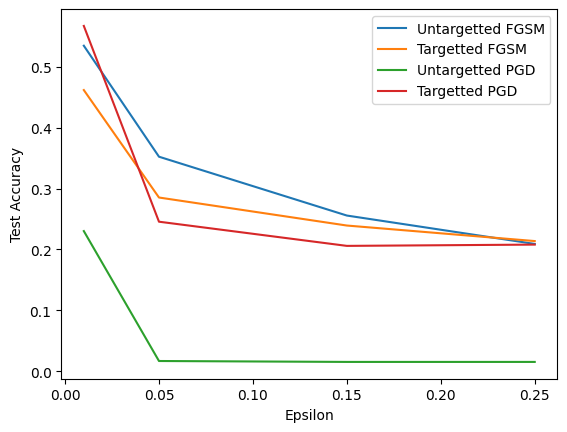

In [14]:
# Plotting the variation of accuracies with epsilon
# plt.plot([0.01,0.05, 0.15, 0.25], U_FGSM_ACC, label="Untargetted FGSM")
# plt.plot([0.01,0.05, 0.15, 0.25], T_FGSM_ACC, label="Targetted FGSM")
# plt.plot([0.01,0.05, 0.15, 0.25], U_PGD_ACC, label="Untargetted PGD")
# plt.plot([0.01,0.05, 0.15, 0.25], T_PGD_ACC, label="Targetted PGD")
# plt.xlabel("Epsilon")
# plt.ylabel("Test Accuracy")
# plt.legend()

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=U_FGSM_ACC, mode='lines+markers', name='Untargetted FGSM'))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=T_FGSM_ACC, mode='lines+markers', name='Targetted FGSM'))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=U_PGD_ACC, mode='lines+markers', name='Untargetted PGD'))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=T_PGD_ACC, mode='lines+markers', name='Targetted PGD'))
fig.update_layout(title="Adversarial Accuracies vs Epsilon", xaxis_title="Epsilon", yaxis_title="Test Accuracy")
fig.show()

## Adversarial Training


In [14]:
# Now performing adversarial training on the model and checking the accuracies again

def adversarial_training(model, train_data, test_data, loss_fn, e=0.1, a=0.01, num_iter=20, num_epochs=10, batch_size=32, lr = 0.001):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for t, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            x.requires_grad = True
            # 5% samples are adversarial
            if np.random.rand() < 0.05:
                for t in range(num_iter):
                    scores = model(x)
                    loss = loss_fn(scores, y)
                    model.zero_grad()
                    loss.backward()
                    x_grad = x.grad.data
                    x_adv = x + a * x_grad.sign()
                    x_adv = torch.min(torch.max(x_adv, x - e), x + e)
                    x_adv = torch.clamp(x_adv, 0, 1)
                    x = x_adv.detach().requires_grad_(True)
            train_preds = model(x)
            loss = loss_fn(train_preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss += loss.item()
        loss /= len(train_loader)
        train_acc, _ = check_acc(train_loader, model, loss_fn)
        print(f'Epoch {epoch}, Train Loss: {loss:.4f}, Train Acc: {train_acc:.4f}')
        eval_model(model, test_data, loss_fn)
    
    # print("Clean Accuracy:")
    # eval_model(model, test_data, loss_fn)

In [19]:
# Testing the adversarial training function
test_model = MyModel(10).to(device=device)
loss_fn = nn.CrossEntropyLoss()

adversarial_training(test_model, train_data, test_data, loss_fn, e=0.1, a=0.01, num_iter=25, num_epochs=20, batch_size=32, lr = 0.0005)

C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\krish\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Train Loss: 0.0018, Train Acc: 0.7367
Test Loss: 0.9013, Test Acc: 0.7248
Epoch 1, Train Loss: 0.0011, Train Acc: 0.8034
Test Loss: 0.7254, Test Acc: 0.7721
Epoch 2, Train Loss: 0.0015, Train Acc: 0.8037
Test Loss: 0.7683, Test Acc: 0.7659
Epoch 3, Train Loss: 0.0008, Train Acc: 0.8629
Test Loss: 0.7307, Test Acc: 0.7928
Epoch 4, Train Loss: 0.0008, Train Acc: 0.8882
Test Loss: 0.6650, Test Acc: 0.8024
Epoch 5, Train Loss: 0.0005, Train Acc: 0.9160
Test Loss: 0.6236, Test Acc: 0.8035
Epoch 6, Train Loss: 0.0005, Train Acc: 0.9092
Test Loss: 0.6591, Test Acc: 0.8019
Epoch 7, Train Loss: 0.0007, Train Acc: 0.9479
Test Loss: 0.5819, Test Acc: 0.8205
Epoch 8, Train Loss: 0.0006, Train Acc: 0.9480
Test Loss: 0.6330, Test Acc: 0.8073
Epoch 9, Train Loss: 0.0006, Train Acc: 0.9170
Test Loss: 0.6765, Test Acc: 0.7875
Epoch 10, Train Loss: 0.0005, Train Acc: 0.9586
Test Loss: 0.7055, Test Acc: 0.8052
Epoch 11, Train Loss: 0.0072, Train Acc: 0.9589
Test Loss: 0.6768, Test Acc: 0.7992
Ep

In [20]:
print("Adversarial Accuracies on Adversarially Trained Model:")
U_FGSM_ACC_adv = []
T_FGSM_ACC_adv = []
U_PGD_ACC_adv = []
T_PGD_ACC_adv = []
for epsilon in [0.01, 0.05, 0.15, 0.25]:
    print("############################")
    print(f"Epsilon = {epsilon}")
    acc1 = eval_untargetted_fgsm(test_model, test_data, loss_fn, e=epsilon)
    acc2 = eval_targeted_fgsm(test_model, test_data, loss_fn, e = epsilon, target_label=torch.full((20,), 7))
    acc3 = eval_untargetted_pgd(test_model, test_data, loss_fn, e=epsilon, a=0.01, num_iter=10)
    acc4 = eval_targeted_pgd(test_model, test_data, loss_fn, target_label=torch.full((20,), 7), e=epsilon, a=0.01, num_iter=30)

    U_FGSM_ACC_adv.append(acc1)
    T_FGSM_ACC_adv.append(acc2)
    U_PGD_ACC_adv.append(acc3)
    T_PGD_ACC_adv.append(acc4)

Adversarial Accuracies on Adversarially Trained Model:
############################
Epsilon = 0.01
Untargetted FGSM Test Loss: 1.9947, Untargetted FGSM Test Acc: 0.5460
Targetted FGSM Test Loss: 1.6842, Targetted FGSM Test Acc: 0.5872
Untargeted PGD Test Loss: 3.0708, Untargeted PGD Test Acc: 0.2817
Targeted PGD Test Loss: 1.4423, Targeted PGD Test Acc: 0.5861
############################
Epsilon = 0.05
Untargetted FGSM Test Loss: 2.7090, Untargetted FGSM Test Acc: 0.3704
Targetted FGSM Test Loss: 2.2625, Targetted FGSM Test Acc: 0.4701
Untargeted PGD Test Loss: 4.4987, Untargeted PGD Test Acc: 0.0547
Targeted PGD Test Loss: 2.1942, Targeted PGD Test Acc: 0.2904
############################
Epsilon = 0.15
Untargetted FGSM Test Loss: 3.1179, Untargetted FGSM Test Acc: 0.2595
Targetted FGSM Test Loss: 2.5669, Targetted FGSM Test Acc: 0.3900
Untargeted PGD Test Loss: 4.5451, Untargeted PGD Test Acc: 0.0489
Targeted PGD Test Loss: 2.2785, Targeted PGD Test Acc: 0.2525
#####################

In [23]:
# # Plotting the variation of accuracies with epsilon
# plt.plot([0.01, 0.05, 0.15, 0.25], U_FGSM_ACC_adv, label="Untargetted FGSM")
# plt.plot([0.01, 0.05, 0.15, 0.25], T_FGSM_ACC_adv, label="Targetted FGSM")
# plt.plot([0.01, 0.05, 0.15, 0.25], U_PGD_ACC_adv, label="Untargetted PGD")
# plt.plot([0.01, 0.05, 0.15, 0.25], T_PGD_ACC_adv, label="Targetted PGD")
# plt.xlabel("Epsilon")
# plt.ylabel("Test Accuracy")
# plt.title("Adversarial Training")
# plt.legend()
# plt.show()
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=U_FGSM_ACC_adv, mode='lines+markers', name='Untargetted FGSM'))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=T_FGSM_ACC_adv, mode='lines+markers', name='Targetted FGSM'))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=U_PGD_ACC_adv, mode='lines+markers', name='Untargetted PGD'))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=T_PGD_ACC_adv, mode='lines+markers', name='Targetted PGD'))
fig.update_layout(title='Adversarial Attacks on Adversarially Trained Model', xaxis_title='Epsilon', yaxis_title='Test Accuracy')
fig.show()



In [27]:
# now plot the 4 adverarially trained models and the clean model one with dotted lines one with non-dotted lines
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=U_FGSM_ACC, mode='lines+markers', name='Untargetted FGSM', line=dict(color='blue',dash='dot')))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=T_FGSM_ACC, mode='lines+markers', name='Targetted FGSM', line=dict(color='red',dash='dot')))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=U_PGD_ACC, mode='lines+markers', name='Untargetted PGD', line=dict(color='green',dash='dot')))
fig.add_trace(go.Scatter(x=[0.01,0.05, 0.15, 0.25], y=T_PGD_ACC, mode='lines+markers', name='Targetted PGD', line=dict(color='purple',dash='dot')))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=U_FGSM_ACC_adv, mode='lines+markers', name='Untargetted FGSM Adv', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=T_FGSM_ACC_adv, mode='lines+markers', name='Targetted FGSM Adv', line=dict(color='red')))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=U_PGD_ACC_adv, mode='lines+markers', name='Untargetted PGD Adv', line=dict(color='green')))
fig.add_trace(go.Scatter(x=[0.01, 0.05, 0.15, 0.25], y=T_PGD_ACC_adv, mode='lines+markers', name='Targetted PGD Adv', line=dict(color='purple')))
fig.update_layout(title="Adversarial Accuracies vs Epsilon for both ResNet-18 and Adversarially Trained ResNet-18", xaxis_title="Epsilon", yaxis_title="Test Accuracy")
fig.show()